# Analisa dados do ENEM

Lê os dados pré-processados que foram gerados pelo notebook `ledados.ipynb` e os analisa. Vá para o final para ver os ranking final.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import IPython
%matplotlib inline
#pd.options.display.max_rows = None
#pd.options.display.max_columns = None



In [2]:
NUM_MELHORES = 65
MIN_ALUNOS = 30 #Mínimo de alunos que fizeram Enem para considerar a escola

In [3]:
CO_SAO_BENTO = 33062633
CO_SAO_VICENTE = 33063648
CO_PARQUE = 33065837
CO_ELEVA = 33178860
CO_ST_INACIO = 33063729
CO_MUN_RIO = 3304557
CO_UF_RIO = 33

In [4]:

df_escolas = pd.read_feather('dados/escolas_rio_2018.feather')
df_primeiro_ano_turmas = pd.read_feather('dados/primeiro_ano.feather')



In [5]:
df_enem_rio = pd.read_feather('dados/enem_rio_2018.feather')


 ## Cálculo da nota final
 Abaixo pode-se personalizar o cálculo de nota final. pondero pelas notas mais importantes.

 O Inep costuma considerar a redação como tendo um peso igual às outras disciplinas.

 Algumas universidades consideram um peso distinto de acordo com a disciplina

 ### Pesos UFRJ

 Referência dos [pesos da UFRJ](https://oglobo.globo.com/sociedade/educacao/ufrj-usara-pesos-diferentes-em-provas-do-enem-2011-para-acesso-aos-cursos-de-graduacao-2865665).

 - Redação: peso 3 (mínimo 300)
 - Ciência da Computação, Ciências Atuariais, Engenharias, Estatística, Matemática e Química Industrial
     - Matemática tem peso 4
 - Ciências Econômicas, Geologia e Meteorologia
     - Matemática peso 3
 - Engenharias e Química Industrial
     - Ciências da Natureza: peso 4
 - Geologia
     - Ciências da Natureza: peso 3
 - Humanas
     - Ciências Humanas e Linguagens: peso 2



In [6]:
notas_cols = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', ]
notas_pesos =(1, 1, 1, 1, 4) #peso do Inep com redação igual os demais

In [7]:
media_ponderada = lambda notas: np.average(notas, weights=notas_pesos)

#df_enem_rio me dá as notas do enem de cada aluno de escola do rio de janeiro 
df_enem_rio['nota_final'] = df_enem_rio.loc[df_enem_rio.TP_ST_CONCLUSAO == 2, notas_cols ]\
                                       .apply(media_ponderada, axis=1)\
                                       .round(0)
df_enem_rio[notas_cols+ ['nota_final']].head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,nota_final
0,468.7,563.8,508.3,513.7,340.0,427.0
1,592.8,706.0,633.1,740.3,820.0,744.0
2,529.6,683.3,652.5,740.3,960.0,806.0
3,483.7,602.4,558.1,453.7,600.0,562.0
4,431.7,560.9,479.7,557.0,560.0,534.0


In [65]:
#df_enem sãos as notas agrupadas por escola e ordenadas da melhor para a pior
def notas_enem(df_enem_rio):
    notas_agg = {col: (col, 'median') for col in notas_cols}
    notas_agg['mediana'] = ('nota_final', 'median')
    notas_agg['num'] = ('nota_final', 'count')

    return df_enem_rio.groupby('CO_ESCOLA')\
                      .agg(**notas_agg)\
                      .sort_values('mediana', ascending=False)\
                      .query('num > @MIN_ALUNOS')#corte arbitrário
df_enem = notas_enem(df_enem_rio)
df_enem

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,mediana,num
CO_ESCOLA,,,,,,,
33057206,646.50,693.00,649.40,768.60,940.0,807.0,83
33135371,662.70,691.40,635.00,763.20,920.0,803.0,91
33062633,689.50,702.85,645.70,801.10,900.0,800.5,62
33165920,645.90,697.60,638.30,768.70,920.0,798.0,51
33055866,668.40,678.50,630.50,755.60,920.0,798.0,31
...,...,...,...,...,...,...,...
33046565,445.05,509.00,469.60,488.55,360.0,430.0,46
33037515,461.30,543.45,504.90,476.00,390.0,429.0,31
33158746,451.05,532.80,481.95,467.35,360.0,427.0,83


In [9]:
df_enem['rank'] = df_enem.mediana.rank(ascending=False, method='min')

In [10]:
#vamos colocar o nome das escolas
df_enem = df_enem.merge(df_escolas[['NO_ENTIDADE', 'CO_ENTIDADE']], left_index=True, right_on='CO_ENTIDADE')

In [11]:
df_enem

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,mediana,num,rank,NO_ENTIDADE,CO_ENTIDADE
1044,646.50,693.00,649.40,768.60,940.0,807.0,83,1.0,INSTITUTO GAYLUSSAC - ENS FUNDAMENTAL E MEDIO,33057206
1517,662.70,691.40,635.00,763.20,920.0,803.0,91,2.0,COLEGIO CRUZEIRO - JACAREPAGUA,33135371
911,689.50,702.85,645.70,801.10,900.0,800.5,62,3.0,COL DE SAO BENTO,33062633
1952,645.90,697.60,638.30,768.70,920.0,798.0,51,4.0,COLEGIO E CURSO PENSI,33165920
760,668.40,678.50,630.50,755.60,920.0,798.0,31,4.0,COL MARILIA MATTOSO,33055866
...,...,...,...,...,...,...,...,...,...,...
549,459.45,531.80,484.00,480.85,360.0,430.0,66,795.0,CE BARAO DE TEFE,33045470
878,445.05,509.00,469.60,488.55,360.0,430.0,46,795.0,CIEP 375 WILSON GREY,33046565
229,461.30,543.45,504.90,476.00,390.0,429.0,31,797.0,CIEP 999 DOM PEDRO DALCANTARA DE BRAGANCA PRIM...,33037515
1619,456.80,533.20,486.65,494.50,360.0,427.0,39,798.0,CIEP 331 LYSIA BERNARDES,33093709


Respondendo uma pergunta sinistra: quantas escolas com ensino médio não tiveram qualquer aluno fazendo Enem?

ih, não dá, já filtrei o df_enem

In [12]:
my_order = df_enem.head(NUM_MELHORES).NO_ENTIDADE

Ajustando nomes de escolas. Estão muito grandes. 


In [13]:
df_nomes_grandes = df_enem[:100][['CO_ENTIDADE', 'NO_ENTIDADE']]
df_nomes_grandes['comprido'] = df_nomes_grandes.NO_ENTIDADE.str.len()
df_nomes_grandes.sort_values('comprido', ascending=False).head(30)

#vamos ajustar alguns nomes
df_enem.loc[df_enem.CO_ENTIDADE==33176825, 'NO_ENTIDADE'] = 'COLEGIO SANTO AGOSTINHO - BARRA'
df_enem.loc[df_enem.CO_ENTIDADE==33066523, 'NO_ENTIDADE'] = 'CAP - UERJ'
df_enem.loc[df_enem.CO_ENTIDADE==33132534, 'NO_ENTIDADE'] = 'GARRA VESTIBULARES - UNID 1'
df_enem.loc[df_enem.CO_ENTIDADE==33057206, 'NO_ENTIDADE'] = 'INSTITUTO GAYLUSSAC'
df_enem.loc[df_enem.CO_ENTIDADE==33142726, 'NO_ENTIDADE'] = 'COL ISRAELITA LIESSIN'
df_enem.loc[df_enem.CO_ENTIDADE==33027722, 'NO_ENTIDADE'] = 'COLEGIO SAGRADO CORACAO DE JESUS'
df_enem.loc[df_enem.CO_ENTIDADE==33065250, 'NO_ENTIDADE'] = 'CAP - UFRJ'
df_enem.loc[df_enem.CO_ENTIDADE==33106754, 'NO_ENTIDADE'] = 'COLEGIO PROF CLOVIS TAVARES PRO-UNI'
df_enem.loc[df_enem.CO_ENTIDADE==33155259, 'NO_ENTIDADE'] = 'COLEGIO SALESIANO REGIAO OCEANICA'

for i, j in (('COLEGIO', 'COL'),
             ('INSTITUTO', 'INST'),
             ('FILIAL', '-'),
             ('UNIDADE ', ''),
             ('PROFESSOR', 'PROF'),
             ('EDUCACIONAL', 'EDUC.'),
            ):
    df_enem['NO_ENTIDADE'] = df_enem.NO_ENTIDADE.str.replace(i, j)

df_nomes_grandes.sort_values('comprido', ascending=False).head(30)    

,CO_ENTIDADE,NO_ENTIDADE,comprido
2061,33176825,COLEGIO SANTO AGOSTINHO - UNIDADE INSTITUTO CU...,68
702,33066523,INSTITUTO DE APLICACAO FERNANDO RODRIGUES DA S...,62
1678,33132534,GARRA VESTIBULARES ASS EDUCACIONAL LTDA - UNID 1,48
1044,33057206,INSTITUTO GAYLUSSAC - ENS FUNDAMENTAL E MEDIO,45
1792,33142726,COL ISRAELITA BRAS A LIESSIN SCHOLEM ALEICHEM,45
329,33027722,COLEGIO FRANCISCANO SAGRADO CORACAO DE JESUS,44
418,33065250,COL DE APLIC DA UNIV FED DO RIO DE JANEIRO,42
1292,33106754,COLEGIO PROFESSOR CLOVIS TAVARES PRO-UNI,40
2156,33155259,ISJB - COLEGIO SALESIANO REGIAO OCEANICA,40
1383,33139989,INSTITUTO GUANABARA LTDA FILIAL BANGU,37


In [14]:
df_enem['rotulo'] = df_enem.loc[:,['NO_ENTIDADE', 'num', 'rank']].apply(lambda x: '{:>s} {:03d}/{:>2.0f}'.format(x[0].title(), x[1], x[2]), axis=1)



In [15]:
df_enem


,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,mediana,num,rank,NO_ENTIDADE,CO_ENTIDADE,rotulo
1044,646.50,693.00,649.40,768.60,940.0,807.0,83,1.0,INST GAYLUSSAC,33057206,Inst Gaylussac 083/ 1
1517,662.70,691.40,635.00,763.20,920.0,803.0,91,2.0,COL CRUZEIRO - JACAREPAGUA,33135371,Col Cruzeiro - Jacarepagua 091/ 2
911,689.50,702.85,645.70,801.10,900.0,800.5,62,3.0,COL DE SAO BENTO,33062633,Col De Sao Bento 062/ 3
1952,645.90,697.60,638.30,768.70,920.0,798.0,51,4.0,COL E CURSO PENSI,33165920,Col E Curso Pensi 051/ 4
760,668.40,678.50,630.50,755.60,920.0,798.0,31,4.0,COL MARILIA MATTOSO,33055866,Col Marilia Mattoso 031/ 4
...,...,...,...,...,...,...,...,...,...,...,...
549,459.45,531.80,484.00,480.85,360.0,430.0,66,795.0,CE BARAO DE TEFE,33045470,Ce Barao De Tefe 066/795
878,445.05,509.00,469.60,488.55,360.0,430.0,46,795.0,CIEP 375 WILSON GREY,33046565,Ciep 375 Wilson Grey 046/795
229,461.30,543.45,504.90,476.00,390.0,429.0,31,797.0,CIEP 999 DOM PEDRO DALCANTARA DE BRAGANCA PRIM...,33037515,Ciep 999 Dom Pedro Dalcantara De Braganca Prim...
1619,456.80,533.20,486.65,494.50,360.0,427.0,39,798.0,CIEP 331 LYSIA BERNARDES,33093709,Ciep 331 Lysia Bernardes 039/798


## Distribuição das notas parece bimodal

Um monte de escolas com notas baixa (500), depois outro grupo com notas mais altas (700). Seria legal ver as distribuições por grupos.

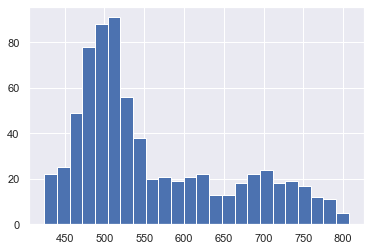

In [16]:
ax = df_enem.mediana.hist(bins=24).plot();
#ax.tick_params(which='both', bottom=False, labelbottom=False)

## Comparando distribuições das escolas

Legenda: Nome da escola <nº alunos fizeram Enem>/<posição ranking nota final>

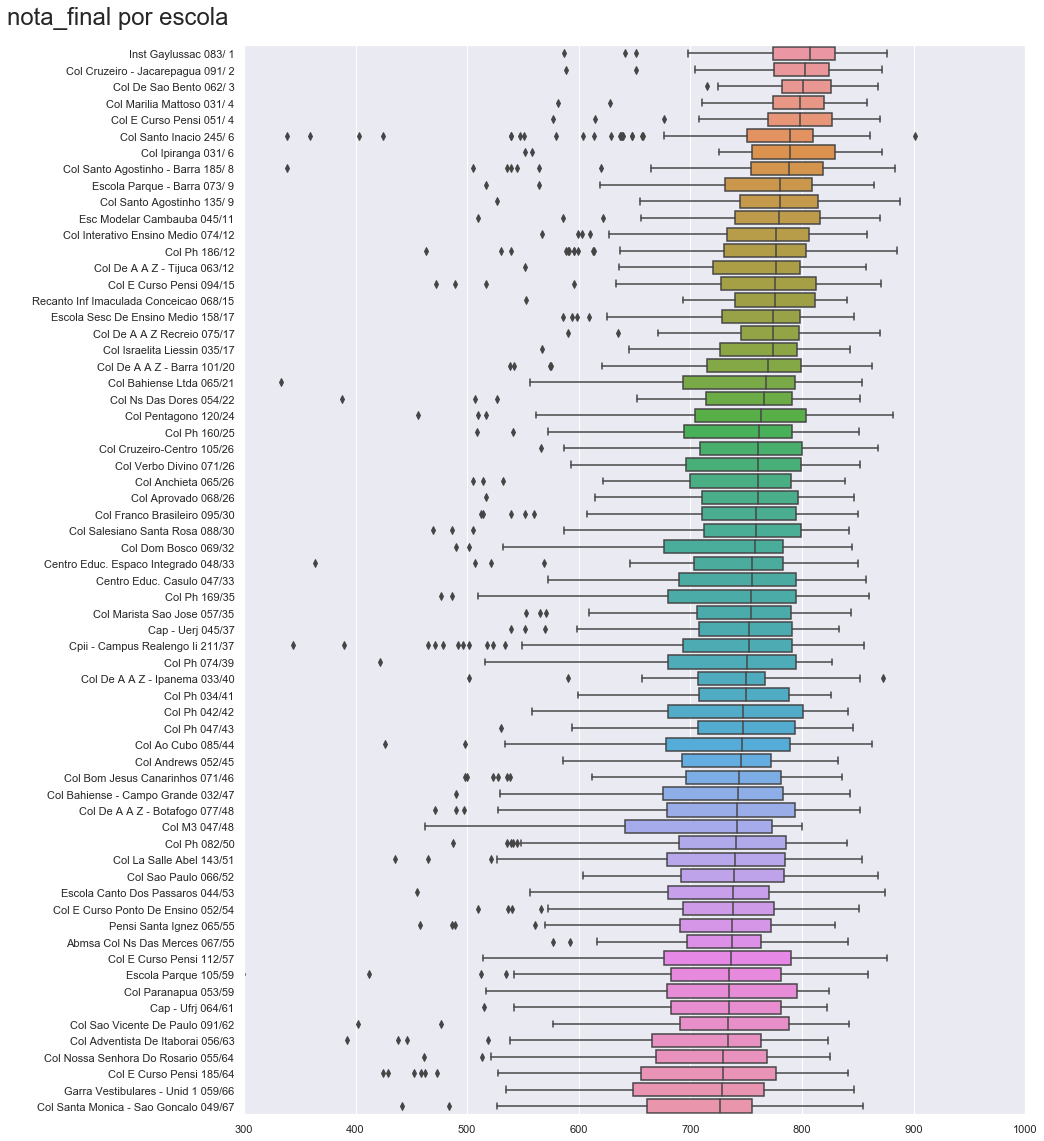

In [17]:


def compara_distribuicoes(nota):
    sns.set(rc={'figure.figsize':(14,18), 'axes.xmargin': .1})
    #sns.palplot(sns.hls_palette(8, l=.3, s=.8))
    
    nota_agrupada = nota
    if nota=='nota_final':
        nota_agrupada = 'mediana'
    
    df_top = df_enem.sort_values(nota_agrupada, ascending=False).head(NUM_MELHORES)
    ax = sns.boxplot(data=df_enem_rio, y='CO_ESCOLA', x=nota, orient='h'
                     ,order=df_top.CO_ENTIDADE)
    ax.set(ylabel='', xlabel='')
    plt.gcf().subplots_adjust(top=.95)
    plt.suptitle(f'{nota} por escola',x=0, size=24, );
    locs, _ = plt.yticks()
    plt.yticks(locs, df_top.rotulo);
    ax.set_xlim(300, 1000)
    

compara_distribuicoes('nota_final');




Um dado estranho, o Santo Inácio tem 245 alunos que disseram que completaram agora, mas há apenas 235 no 3º ano de 2018. Será que é preenchimento errado? Será que estou contando jovens e adultos? Será que acontece o mesmo com outras escolas?

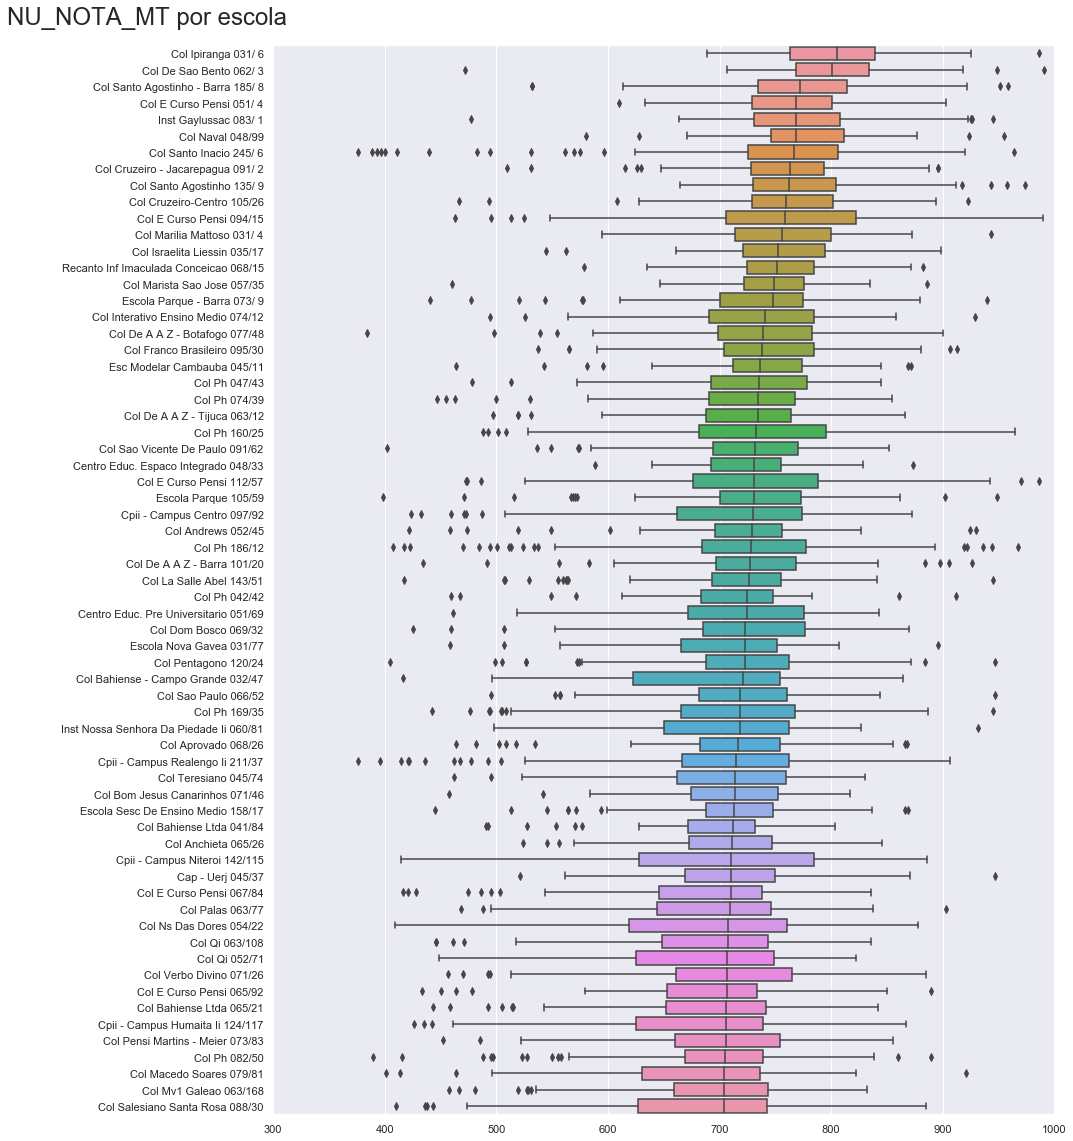

In [18]:
compara_distribuicoes('NU_NOTA_MT');

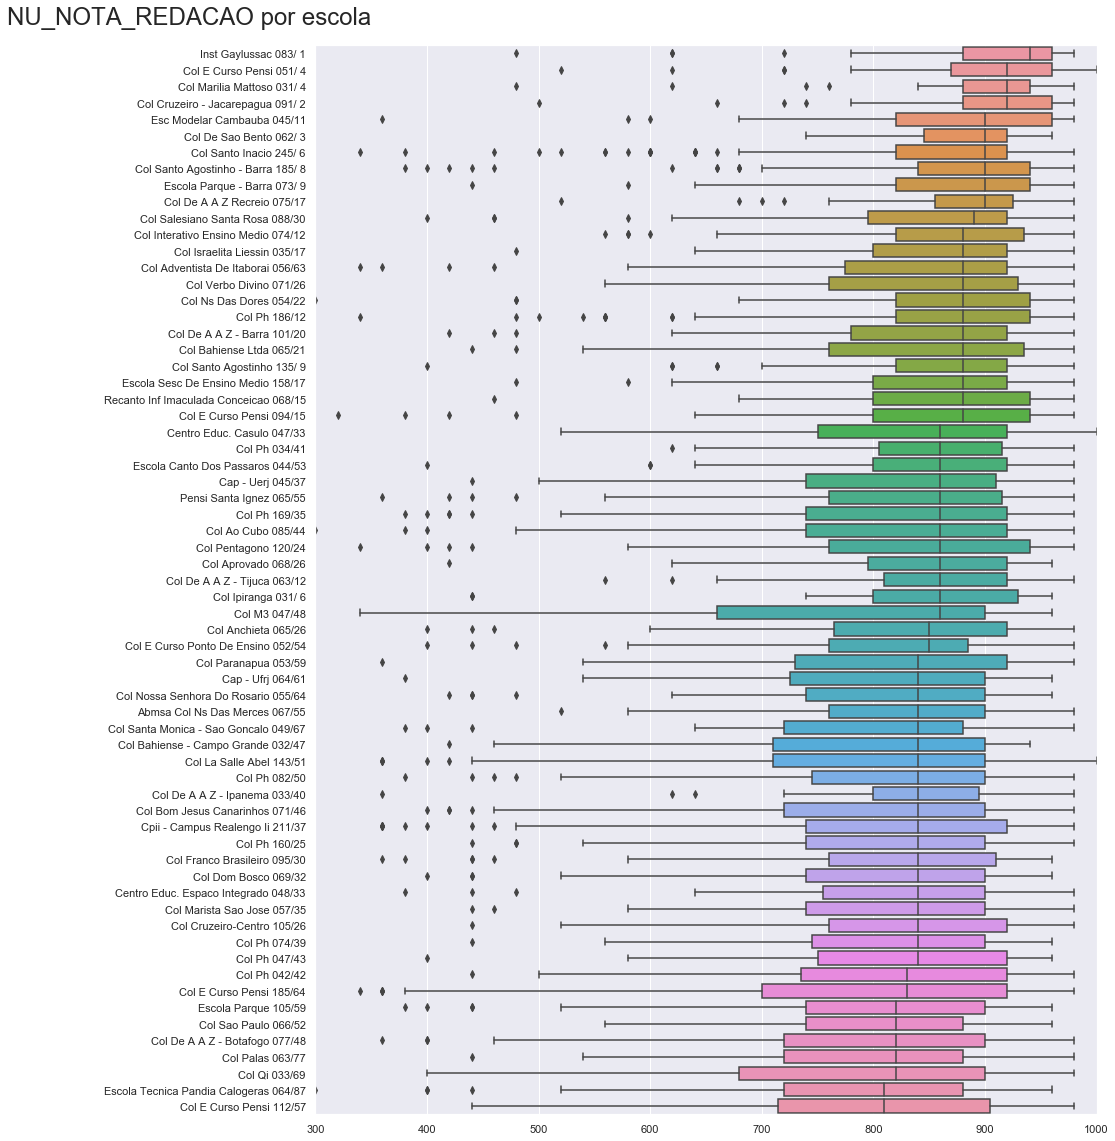

In [19]:
compara_distribuicoes('NU_NOTA_REDACAO');



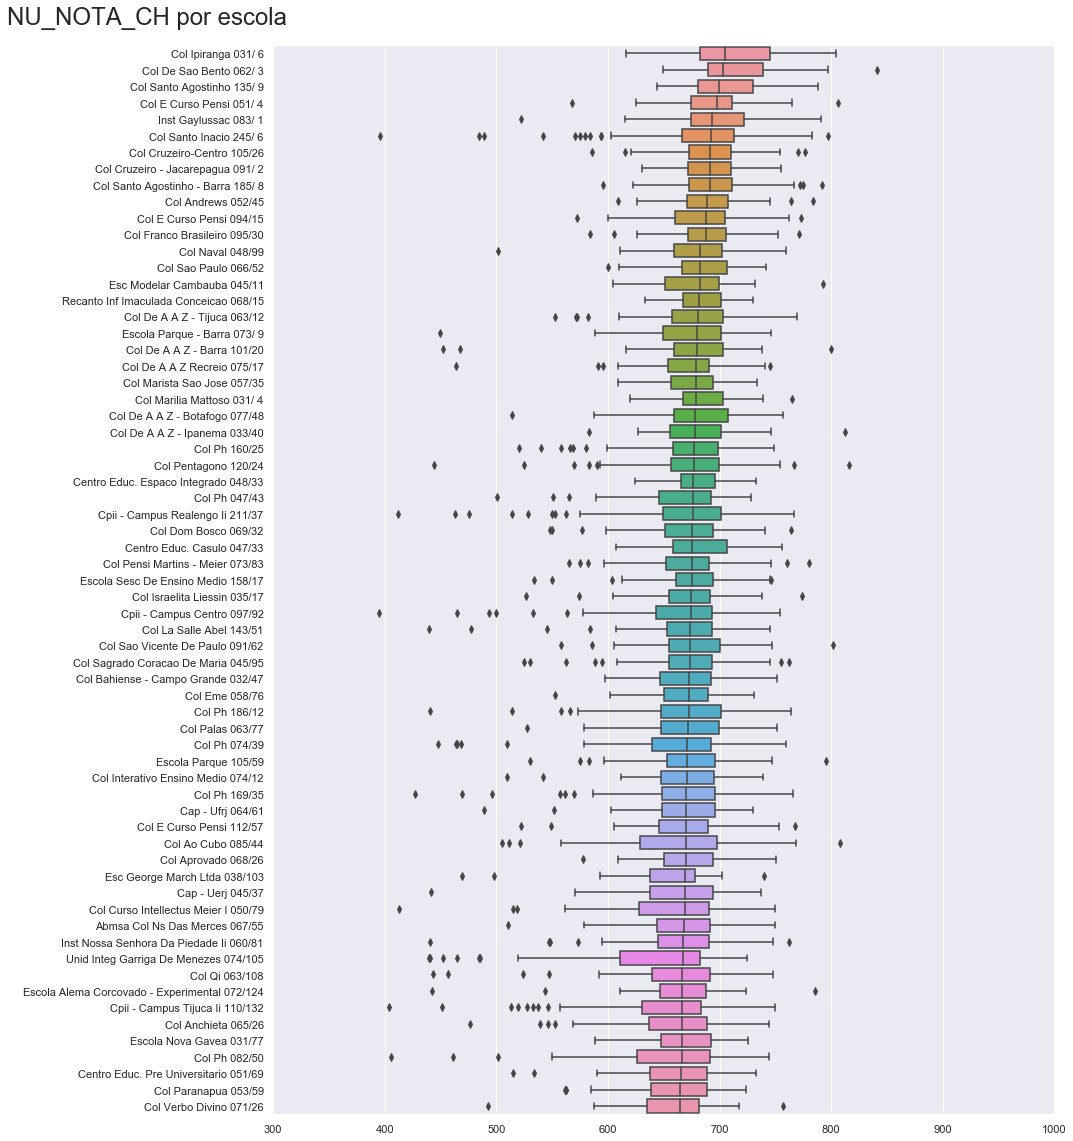

In [20]:
compara_distribuicoes('NU_NOTA_CH');


 ## Sobrevivência no ensino médio

 Quantos dos alunos que começam o ensino médio fazem Enem?

 Motivos para diminuir:
 - Maus alunos são expulsos
 - Maus alunos não acreditam que passarão no Enem
 - Vai para universidade fora do Enem (ITAs, PUCs, USP, exterior etc.)

 Motivos para aumentar:
 - Crise econômica (escolas públicas)
 - Bolsa para bons alunos

 ### ideias
 - comparar com último ano (dá ideia melhor da seleção feita pela escola)
 - comparar com quem fez prova (ideia melhor de auto seleção)

In [21]:
etapa_col = 'TP_ETAPA_ENSINO'
primeiro_ano = [25,  30, 35]
# todo: tratar ensinos médios de 4 anos
df_primeiro_ano_turmas = pd.read_feather('dados/primeiro_ano.feather')




In [22]:
df_ano_um = df_primeiro_ano_turmas.groupby(['id_escola', 'ano'])['num_matriculas'].sum()
CO_ELEVA=33178860
df_ano_um = df_ano_um.unstack()
df_ano_um



ano,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
id_escola,,,,,,,,,,,,
33000026,90.0,73.0,51.0,36.0,55.0,63.0,54.0,51.0,56.0,41.0,39.0,35.0
33000042,216.0,194.0,177.0,111.0,128.0,138.0,104.0,99.0,98.0,121.0,86.0,58.0
33000069,26.0,25.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33000077,108.0,102.0,149.0,194.0,207.0,210.0,228.0,230.0,262.0,291.0,280.0,274.0
33000115,NaN,NaN,NaN,23.0,6.0,15.0,7.0,12.0,9.0,21.0,22.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...
33551219,NaN,NaN,NaN,41.0,48.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN
33552223,NaN,NaN,NaN,NaN,11.0,NaN,4.0,7.0,5.0,NaN,4.0,2.0
33552231,NaN,NaN,NaN,13.0,15.0,20.0,29.0,20.0,33.0,18.0,20.0,19.0


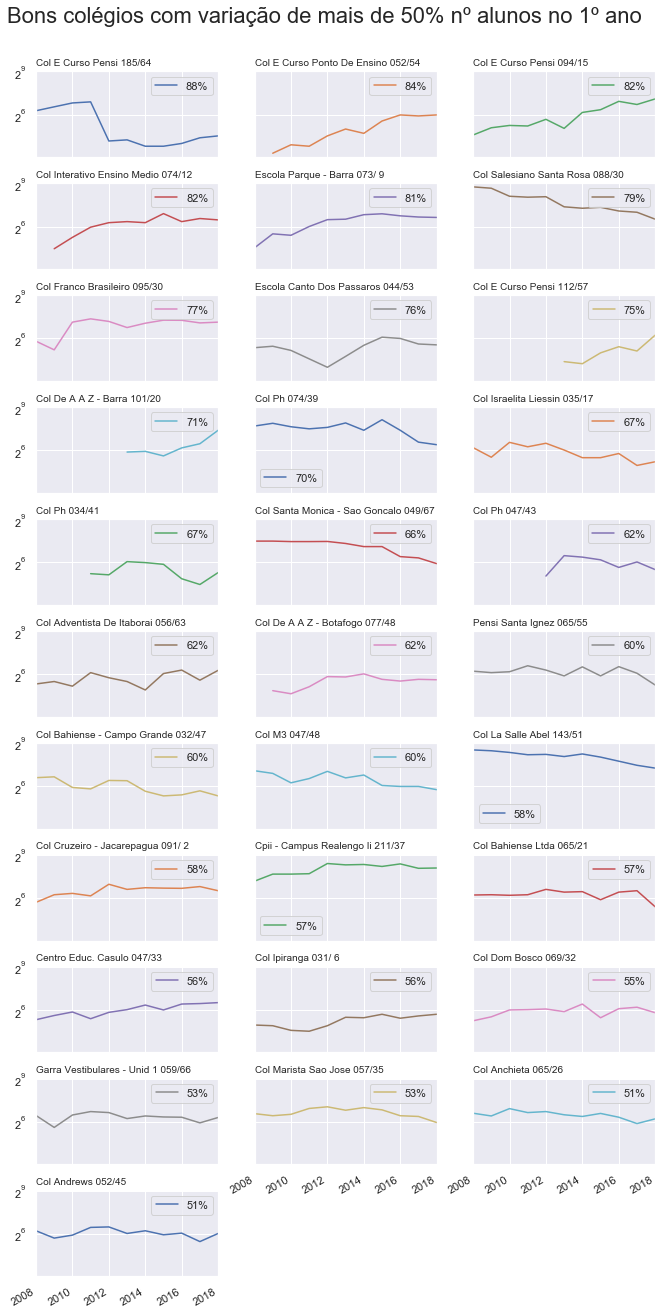

In [38]:
df_ano_um[df_ano_um==1] = np.nan  # tem um Pensi aqui com dado esquisito
porcentagem_variacao = .5
anos_idx = slice(0, 11) #colunas com dados de alunos no primeiro ano
df = (df_ano_um.drop(2007, axis='columns')
          .merge(df_enem.head(NUM_MELHORES)[['CO_ENTIDADE', 'rotulo', 'rank']], 
                 left_index=True, right_on='CO_ENTIDADE') #pegando nome das escolas e só das melhores
         .set_index('rotulo')
         .assign(alta_variacao=  #variação do número de alunos
                 lambda df: (df.iloc[:,anos_idx].max(axis='columns') - df.iloc[:,anos_idx].min(axis='columns'))
                            /df.iloc[:,anos_idx].max(axis='columns'))
         .query('alta_variacao > @porcentagem_variacao')
         .sort_values('alta_variacao', ascending=False) #mostrando primeiro as com maior variação
         .drop(['CO_ENTIDADE', 'rank'], axis='columns')
         .dropna(thresh=6) # joga fora quem não tem pelo menos 6 anos preenchidos
     )
alta_variacao = df.pop('alta_variacao')
df = df.T

sns.set(rc={'figure.figsize':(10,18), 'axes.xmargin': .1})
axes = df.plot.line(subplots=True, layout=(11,3), sharey=True);

i = 0
for axes2 in axes:
    for ax in axes2:
        if i < len(alta_variacao): 
            ax.set_title(df.columns[i], ha='left', x=0, size=10)
            #ax.legend().set_visible(False)
            ax.legend(['{:.0%}'.format(alta_variacao.iloc[i])])
            ax.set_yscale("log", basey=2)
        i += 1
sns.set()
fig = plt.gcf()
fig.suptitle("Bons colégios com variação de mais de {:.0%} nº alunos no 1º ano".format(porcentagem_variacao), 
                 size=22, ha='left', x=0);
plt.subplots_adjust(hspace=.3, wspace=.2, left=.04, top=.93, bottom=0)
plt.xticks(range(2008, 2019));

Escrito na legenda acima está a variação entre o máximo e mínimo de alunos do primeiro ano de cada escola.

- Pensi tem grandes variações, tanto uma queda drástica em 2012, como um grande crescimento
- Vários colégios de Niterói/São Gonçalo perdendo alunos:  Salesiano Santa Rosa, Abel, Santa Mônica
- escola parque barra crescendo
- PH varia muito (com queda drástica no final)

## Comparando nº alunos que fizeram ENEM vs alunos no 1º ano

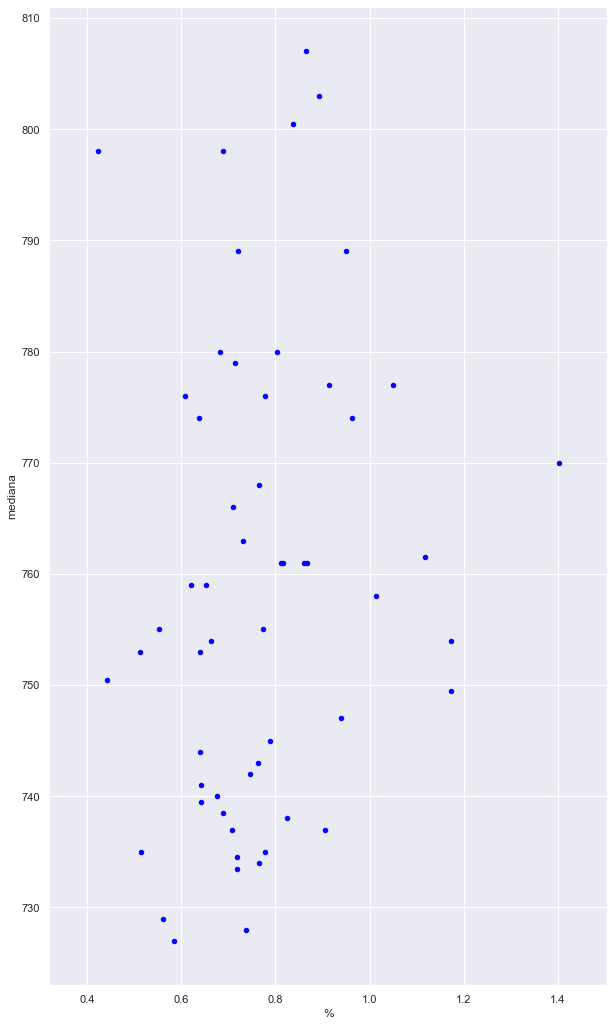

In [39]:
df = df_enem.head(NUM_MELHORES).set_index('CO_ENTIDADE')
df = df.join(df_ano_um[[2016]] )
df['%'] = df.num/df[2016]
# tirando do plot alguns outliers. Tem escola com 10 vezes mais alunos!
df[df['%']<1.5].plot.scatter(x='%', y='mediana', c='blue'); 

Entre os bem colocados, quem aumenta o número de alunos?

In [26]:
df.loc[df['%']>=1, ['rotulo', '%', 'mediana', 'rank', 'num']].sort_values('%', ascending=False)

,rotulo,%,mediana,rank,num
CO_ENTIDADE,,,,,
33150931,Col E Curso Pensi 185/64,11.562500,729.0,64.0,185
33166820,Col E Curso Pensi 112/57,2.604651,736.5,57.0,112
33173990,Col De A A Z - Tijuca 063/12,1.968750,777.0,12.0,63
33228604,Col De A A Z - Botafogo 077/48,1.673913,742.0,48.0,77
33447225,Col De A A Z - Barra 101/20,1.402778,770.0,20.0,101
33110328,Col Ph 169/35,1.173611,754.0,35.0,169
33157901,Col Ph 034/41,1.172414,749.5,41.0,34
33105405,Col Ph 160/25,1.118881,761.5,25.0,160
33153450,Col Ph 186/12,1.050847,777.0,12.0,186


Quem aumenta o número de alunos? Pensi, de A a Z e PH. Estes são mais cursinhos pré-vestibular do que escolas. Vou tirá-los da lista. O Colégio [Dom Bosco](https://www.colegiodombosco.com.br/) é um colégio tradicional de Resende, então vou manter.

A correlação de 0.24 entre notas e perdas de alunos é fraca


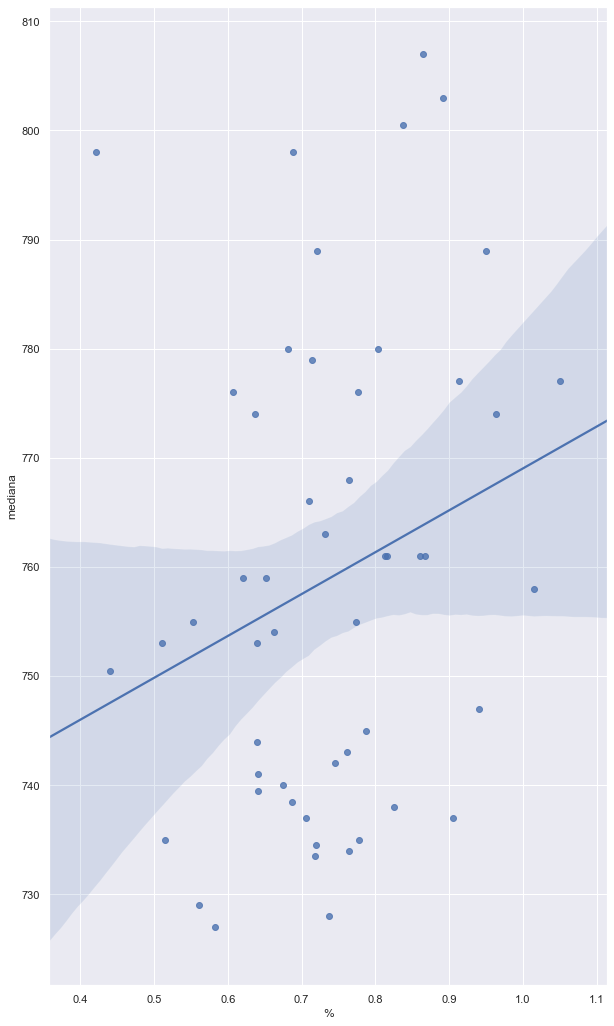

In [27]:
df_sem_outliers = df[df['%']<1.06]
sns.set()
sns.regplot(data=df_sem_outliers, x='%', y='mediana');
print("A correlação de {:.2n} entre notas e perdas de alunos é fraca".format(df_sem_outliers[['%', 'mediana']].corr().iat[0,1]))

In [28]:
df.loc[:, ['rotulo', 2016, 'num', '%', 'mediana', 'rank']].style.hide_index().format({'%': '{:.0%}'.format})

rotulo,2016,num,%,mediana,rank
Inst Gaylussac 083/ 1,96,83,86%,807,1
Col Cruzeiro - Jacarepagua 091/ 2,102,91,89%,803,2
Col De Sao Bento 062/ 3,74,62,84%,800.5,3
Col E Curso Pensi 051/ 4,121,51,42%,798,4
Col Marilia Mattoso 031/ 4,45,31,69%,798,4
Col Santo Inacio 245/ 6,258,245,95%,789,6
Col Ipiranga 031/ 6,43,31,72%,789,6
Col Santo Agostinho - Barra 185/ 8,nan,185,nan%,788,8
Escola Parque - Barra 073/ 9,107,73,68%,780,9
Col Santo Agostinho 135/ 9,168,135,80%,780,9


Entre os que mais diminuem o número de alunos também estão o Pensi e o PH. Impressionante, o CAP da Uerj tem bem poucos alunos fazendo Enem. Vamos dar uma olhada como os colégios que também são cursos variam de número de alunos.

In [44]:
df_cursos = df.loc[(df.rotulo.str.contains('Ph|Curso Pensi|A A Z')),['rotulo', 'mediana', 'rank', '%']]
df_cursos.style.hide_index().format({'%': '{:.0%}'.format})

rotulo,mediana,rank,%
Col E Curso Pensi 051/ 4,798,4,42%
Col Ph 186/12,777,12,105%
Col De A A Z - Tijuca 063/12,777,12,197%
Col E Curso Pensi 094/15,776,15,78%
Col De A A Z Recreio 075/17,774,17,nan%
Col De A A Z - Barra 101/20,770,20,140%
Col Ph 160/25,761.5,25,112%
Col Ph 169/35,754,35,117%
Col Ph 074/39,750.5,39,44%
Col De A A Z - Ipanema 033/40,750,40,nan%


A variação de alunos destes cursos é impressionante. O melhor colocado tem menos de metade dos alunos do início do ensino médio. Enquanto outros tem um aumento impressionante. Não parece uma comparação justa com as escolas mais tradicionais. 

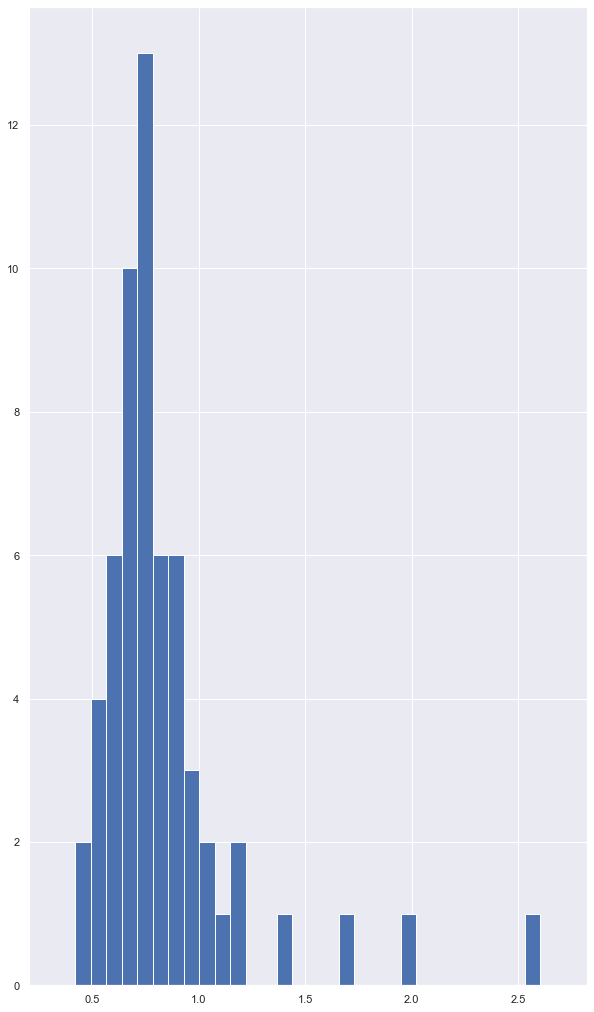

In [30]:
df.loc[df['%']<4, '%'].hist(bins=30).plot();

In [31]:
df.loc[df['%']<4, '%'].describe()

count    59.000000
mean      0.837354
std       0.353053
min       0.421488
25%       0.657321
50%       0.761905
75%       0.879963
max       2.604651
Name: %, dtype: float64

In [32]:
df['%'].quantile([i/10 for i in range(11)])

0.0     0.421488
0.1     0.581122
0.2     0.640428
0.3     0.685923
0.4     0.718640
0.5     0.763305
0.6     0.794156
0.7     0.861907
0.8     0.941922
0.9     1.172534
1.0    11.562500
Name: %, dtype: float64

In [61]:
# isso aqui é enrolado. Entre as NUM_ESCOLAS melhores escolas, quais mais cortam alunos entre 
# primeiro ano e o Enem? 
menor_quantil = df['%'].quantile(.2) #arbitrário
menor_quantil

0.6404279279279279

## Seleção de escolas para ranking

Retirando quem eu não quero contar:
- quem aumenta o número de alunos (só fica o Dom Bosco com variação 1.02)
- quem corta aluno demais, isto é os 80% que menos cortam, isto é, pelo menos 64% dos alunos do 1º ano devem fazer Enem (não verifico se são os mesmos alunos). Isso privilegia as escolas que menos cortam alunos. Por outro lado prejudica escolas cujos bons alunos foram para outra escola.
- Pelo menos 35 alunos fazendo Enem. 


Os 2 primeiro critérios cortam quase todos os cursinhos: Pensi, A a Z e PH

E depois vem o critério mais radical. Contarei quantos alunos eriam 64% do primeiro ano e contarei apenas este número das melhores notas. Isto privilegiará as escolas que mantém um número de alunos constante do primeiro ao último ano do ensino médio. 

In [73]:
df_escolas_selecionadas = df.loc[(df['%'] < 1.02) &
                                 (df['%'] >= menor_quantil) & 
                                 (df['num'] >= 35),
                                 
                                 ['rotulo', 2016, '%']
                                ]
print("Antes dos cortes tínhamos {:n} melhores escolas, depois ficamos com {:n}, cortando {:.1%}"
      .format( NUM_MELHORES, len(df_escolas_selecionadas), (NUM_MELHORES-len(df_escolas_selecionadas))/NUM_MELHORES) )

Antes dos cortes tínhamos 65 melhores escolas, depois ficamos com 36, cortando 44.6%


Agora vem o radical, pegaremos apenas os melhores 64 percentil das notas.

In [97]:
#df_escolas_selecionadas ['num_candidatos_considerados'] = (df_escolas_selecionadas[[2016]] * menor_quantil).round().astype('int16')
df_escolas_selecionadas ['num_candidatos_considerados'] = (df_escolas_selecionadas[[2016]] * .7).round().astype('int16')
df_escolas_selecionadas

,rotulo,2016,%,num_candidatos_considerados
CO_ENTIDADE,,,,
33057206,Inst Gaylussac 083/ 1,96.0,0.864583,67
33135371,Col Cruzeiro - Jacarepagua 091/ 2,102.0,0.892157,71
33062633,Col De Sao Bento 062/ 3,74.0,0.837838,52
33063729,Col Santo Inacio 245/ 6,258.0,0.949612,181
33148376,Escola Parque - Barra 073/ 9,107.0,0.682243,75
33065403,Col Santo Agostinho 135/ 9,168.0,0.803571,118
33085897,Esc Modelar Cambauba 045/11,63.0,0.714286,44
33447250,Col Interativo Ensino Medio 074/12,81.0,0.913580,57
33135827,Col E Curso Pensi 094/15,121.0,0.776860,85


In [98]:

df_melhores_alunos = pd.concat(g.nlargest(df_escolas_selecionadas.at[escola_id, 'num_candidatos_considerados'], columns='nota_final') 
                               for escola_id, g in df_escolas_selecionadas[['rotulo']]
                                                    .merge(df_enem_rio.sort_values(['CO_ESCOLA', 'nota_final']), left_index=True, right_on='CO_ESCOLA')
                                                    .groupby('CO_ESCOLA')
                     )
df_final = notas_enem(df_melhores_alunos).join(df_escolas_selecionadas[['rotulo']])
df_final['rank'] = df_final.mediana.rank(ascending=False, method='first')
df_final

#     notas_agg = {col: (col, 'median') for col in notas_cols}
#     notas_agg['mediana'] = ('nota_final', 'median')
#     notas_agg['num'] = ('nota_final', 'count')

#     return df_enem_rio.groupby('CO_ESCOLA')\
#                       .agg(**notas_agg)\
#                       .sort_values('mediana', ascending=False)\
#                       .query('num > @MIN_ALUNOS')#corte arbitrário

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,mediana,num,rotulo,rank
CO_ESCOLA,,,,,,,,,
33057206,652.70,702.70,657.50,786.60,940.0,821.0,67,Inst Gaylussac 083/ 1,1.0
33135371,672.70,699.40,645.10,767.70,940.0,814.0,71,Col Cruzeiro - Jacarepagua 091/ 2,2.0
33062633,691.25,706.85,648.55,811.45,920.0,809.5,52,Col De Sao Bento 062/ 3,3.0
33063729,661.50,699.10,635.80,778.50,920.0,798.0,181,Col Santo Inacio 245/ 6,4.0
33065403,661.45,701.70,650.90,767.25,880.0,790.0,118,Col Santo Agostinho 135/ 9,5.0
33447250,639.40,682.30,623.50,762.30,900.0,790.0,57,Col Interativo Ensino Medio 074/12,6.0
33322201,639.60,681.40,640.20,724.30,900.0,787.0,115,Escola Sesc De Ensino Medio 158/17,7.0
33062609,656.70,691.90,640.90,765.20,880.0,784.0,85,Col Cruzeiro-Centro 105/26,8.0
33135827,652.60,689.30,627.70,762.00,900.0,781.0,85,Col E Curso Pensi 094/15,9.0


In [35]:
#dever de casa

analisar colégios que estão com NAN na percentagem acima, especialmente o **Santo Agostinho Barra**